# TB231c - abm model 1 - simple economy - Part 2
This is a model of a very simplistic economy. Code is based on the mesa tutorial model found here : https://mesa.readthedocs.io/en/stable/tutorials/intro_tutorial.html

Goal of these exercises is :
* Get acquainted (more) with mesa
* work with DataCollector
* understand the effect of random
* understand the effect of different agent scheduling mechanisms on individual and system level properties


In [1]:
#library imports:
#mesa
from mesa import Agent, Model
from mesa.datacollection import DataCollector
#load all available schedulers
import mesa.time as time

# matplot lib for plotting, numpy for all sorts of useful math
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
# For a jupyter notebook we have to tell matplotlib to draw graphs inline
%matplotlib inline

#basic python statistics
import statistics as stat

#import pandas
import pandas as pd

# Required libraries for animation
from matplotlib.animation import FuncAnimation
from matplotlib import animation, rc, collections
from IPython.display import HTML

# Part 2 - Individual properties over time - 
## DataCollectors 
The approach we used in part 1 works fine, as long as you know what you want to plot in advance, and running  the model is quick. 
However, when the simulation takes a long time, and you want to decide later what the relevant plots are, we need to collect simulation data in a more systematic way.

Mesa has a way to do that with the DataCollector class.

We will modify the agent and model compared to the version we used last week.

In [2]:
# Define the data collection functions, that will be used by the DataCollector :

def get_agents_wealth(model):
    """Returns a list with wealth values for all agents """
    return [a.wealth for a in model.schedule.agents]


def get_wealth_and_id_richest(model):
    """Returns the identify and wealth the richest agent as a two element tuple"""
    richest_agent = None
    max_wealth = -99999

    for a in model.schedule.agents:
        if a.wealth > max_wealth:
            richest_agent = a
            max_wealth = a.wealth
    return richest_agent.unique_id,max_wealth

def max_wealth(model):
    return get_wealth_and_id_richest(model)[1]

def richest(model):
        return get_wealth_and_id_richest(model)[0]

def get_step_number(model):
        return model.schedule.steps

In order to use these functions, we must define the DataCollector in the model.

In [3]:
# the model with data collector

class MoneyAgent(Agent):
    """ An agent with fixed initial wealth."""
    def __init__(self, unique_id, model, max_init_money , max_take_money):
        super().__init__(unique_id, model)
        self.wealth = self.random.randrange(max_init_money)
        self.max_take_money = max_take_money
      
    def step(self):
 
        other_agent = self.random.choice(self.model.schedule.agents)
        money_to_take = self.random.randrange(self.max_take_money)
        
        #we can not take more than the other agent has
        #so, determine how much the other has, if we are taking less than what they have , take it
        # if not, take all they got, untill they have 0
        
        available_to_take = other_agent.wealth
        
        if available_to_take >= money_to_take:
            other_agent.wealth -= money_to_take
            self.wealth += money_to_take
        else:
            #take all they have
            self.wealth += other_agent.wealth
            other_agent.wealth = 0
      
class MoneyModel(Model):
    """A model with some number of agents."""
    def __init__(self, N, max_init_money = 100, max_take_money = 10,seed=None):
        self.num_agents = N
        self.schedule = time.RandomActivation(self)
        
        #the data collector, defines which variables will eb collected, and how
        model_metrics = {
                "step":get_step_number,
                "agent_wealth":get_agents_wealth,
                "max_wealth":max_wealth,
                "richest_agent":richest,
            }
        #TODO add explanation
        agent_metrics = {
            "wealth":"wealth"
        }
        self.datacollector = DataCollector(model_reporters=model_metrics,agent_reporters=agent_metrics)
    
        # Create agents
        for i in range(self.num_agents):
            a = MoneyAgent(i, self, max_init_money, max_take_money )
            self.schedule.add(a)

    def step(self):
        '''Advance the model by one step.'''  
        #collect the model data 
        self.datacollector.collect(self)
        #run the step
        self.schedule.step()


In [4]:
#run the model

model = MoneyModel(100)

for i in range(100):
    model.step()
    

In [5]:
get_wealth_and_id_richest(model)

(73, 227)

In [6]:
#Get the Pandas Dataframe from the model, by using the table name we defined in the model
model_data = model.datacollector.get_model_vars_dataframe()
agent_data = model.datacollector.get_agent_vars_dataframe()

## Pandas and DataFrames
From now on we will be using Pandas DataFrames for storing our data. This is the most popular and very powerful library for data manipulation. Pandas and data manipulation will not be part of the exam, but you will have to use it all the time.

For more background see :
* Pandas in 10 minutes:  https://pandas.pydata.org/pandas-docs/stable/user_guide/10min.html
* Pandas cheat sheet : https://pandas.pydata.org/Pandas_Cheat_Sheet.pdf
* Pandas docummentation : https://pandas.pydata.org/docs/

In [7]:
# Notice the column without the name, that is the index. Each column has a name, which is defined in the DataCollector.
# Also notice that we are storing a list in the agent_wealth column.
model_data.head()

,step,agent_wealth,max_wealth,richest_agent
0,0,"[4, 98, 27, 65, 11, 2, 12, 11, 13, 80, 92, 98,...",99,27
1,1,"[1, 86, 22, 61, 6, 7, 14, 0, 4, 82, 89, 97, 70...",99,21
2,2,"[3, 87, 24, 42, 11, 6, 14, 0, 12, 84, 87, 97, ...",101,21
3,3,"[0, 84, 29, 46, 3, 7, 12, 0, 4, 88, 96, 92, 66...",105,24
4,4,"[0, 83, 29, 53, 4, 7, 3, 6, 9, 91, 99, 93, 50,...",110,73


In [ ]:
# Q : .head() gives you the top of the DataFrame. How would you get the last few lines ? 

In [8]:
#lets look at Agent level dataframe. Note that it has  only one column "wealth" but it has 2 indices.
#In Pandas this is a hierarchical MultiIndex : https://pandas.pydata.org/pandas-docs/stable/user_guide/advanced.html 
agent_data.tail()

wealth
Step AgentID        
99   95          152
     96          129
     97          105
     98           43
     99           64

# Accessing DataFrame data :
Please find a quick tutorial on accessing various data in a pandas DataFrame : 
* https://www.geeksforgeeks.org/indexing-and-selecting-data-with-pandas/#:~:text=Indexing%20in%20pandas%20means%20simply,be%20known%20as%20Subset%20Selection.

Lets practice this a bit :

In [ ]:
# Find the richest agent in step 42 in model_data

# Find the wealth of agent 32 at step 42 in agent_data table

# More advanced
# Find the highest wealth that has ever occured, and determine at which step / at which agent in agent_data 

In [ ]:
# Lets look at the data

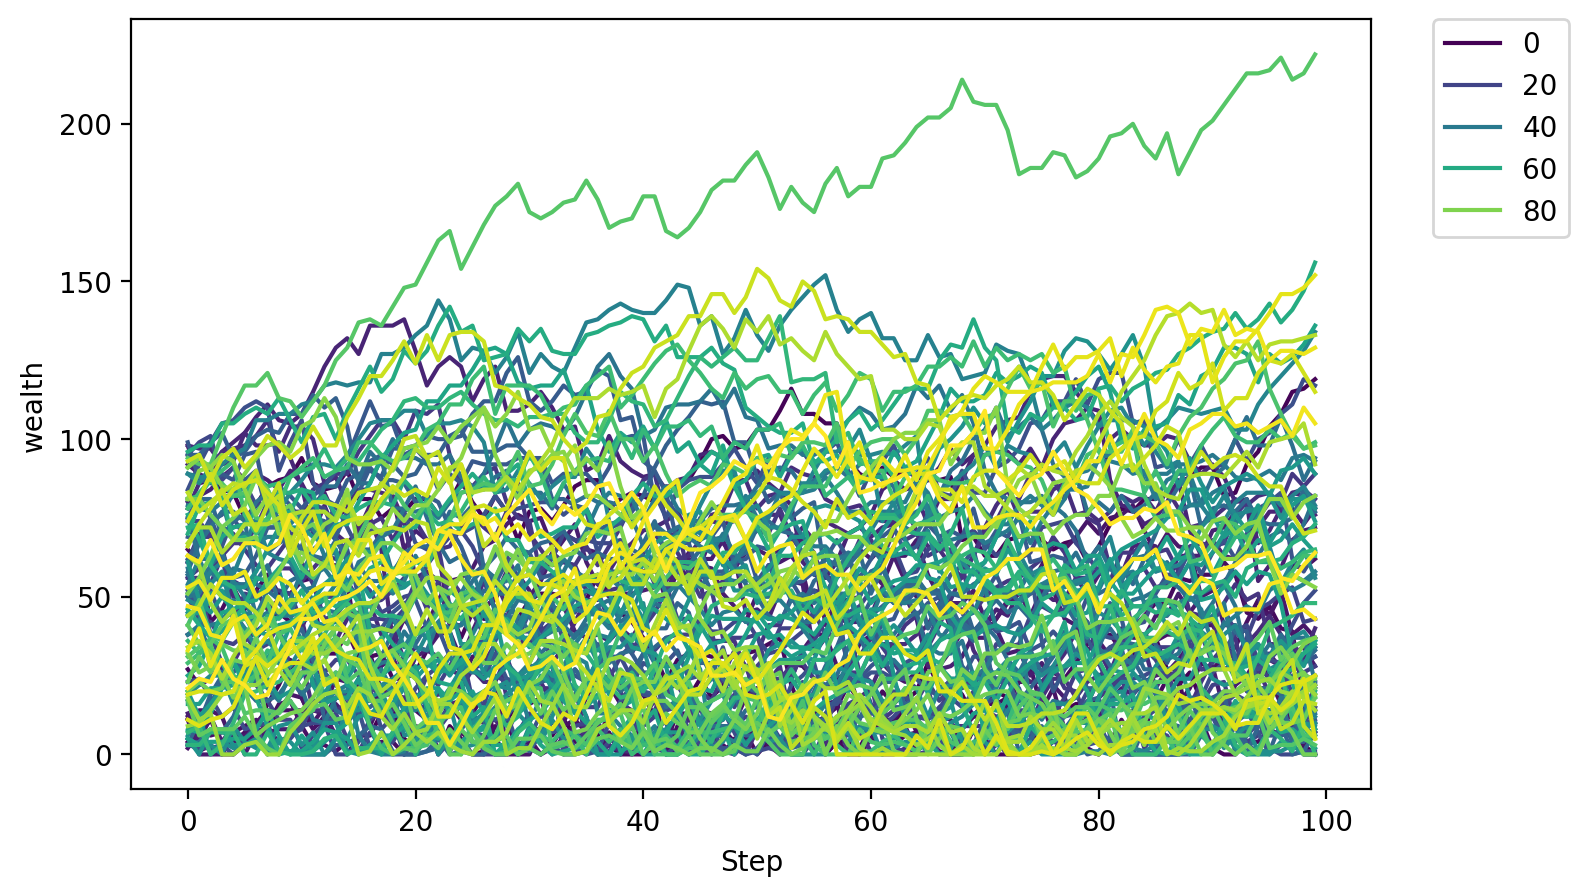

In [9]:
# Now lets see what is each agents wealth over time

#Here we specify how large the image will be. In this case  in 8 inches by  5 inches. We also specify that 200 dots per inch should be used. 
# This means that the final figure will be 8 * 200 x 5 * 200 pixels.
fig, ax = plt.subplots(figsize=(8,5), dpi=200)

#Notice the hue argument. Hue tell seaborn where to find the categories it whould plot.
#ax = sns.lineplot(data = agent_data,  x='Step',y='wealth', hue='AgentID',palette='viridis')
ax = sns.lineplot(data = agent_data,  x='Step',y='wealth', hue='AgentID',palette='viridis')

#this moves the label box outside the image.
ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0)

Text(0.5, 1.0, 'Wealth of the richest agent over time')

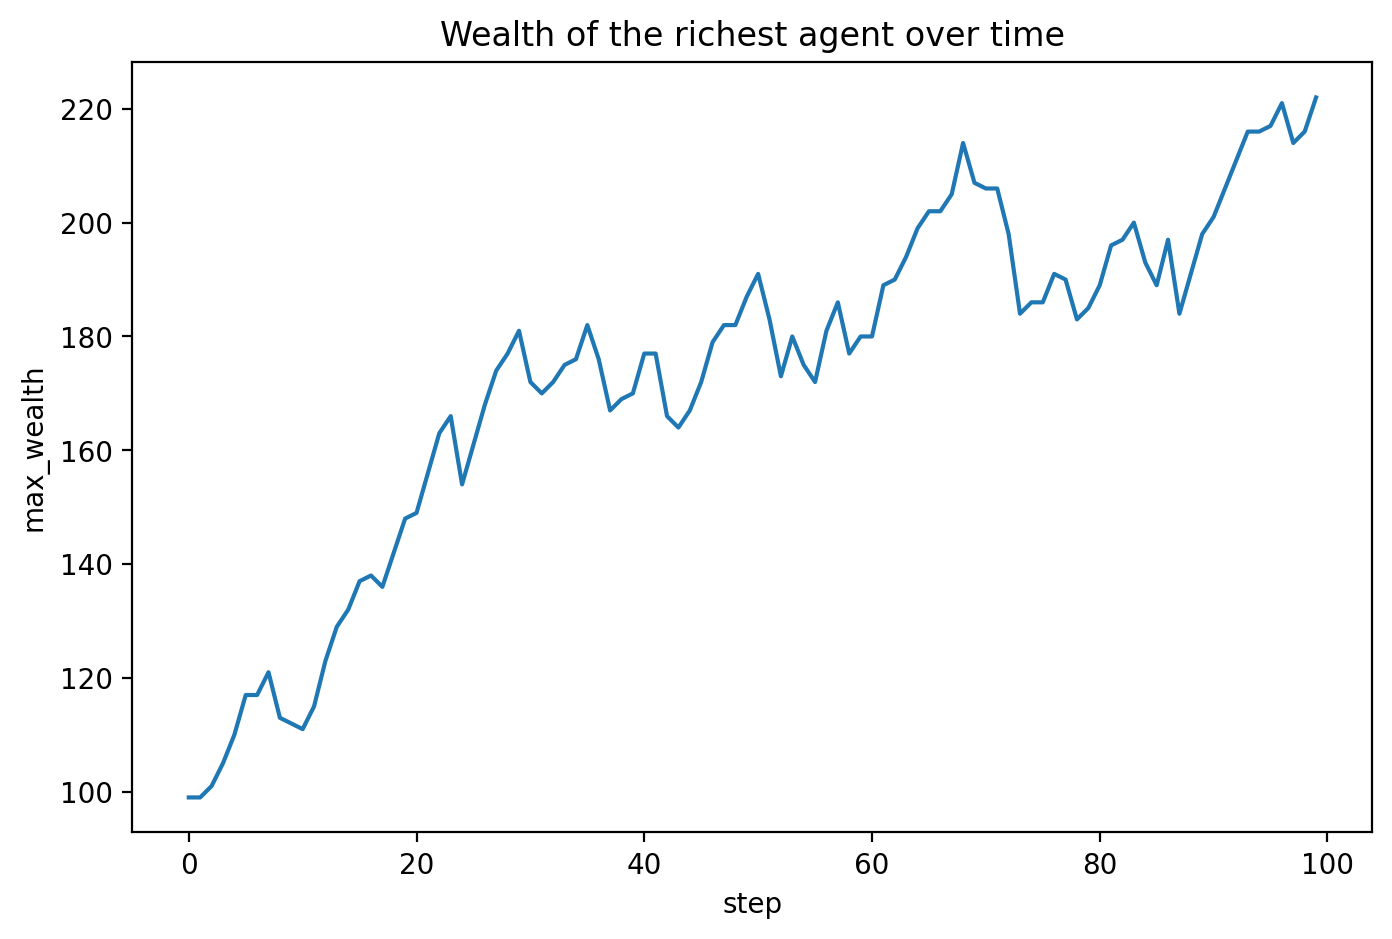

In [10]:
#Plot the wealth of the richest agent over time
fig, ax = plt.subplots(figsize=(8,5), dpi=200)
ax = sns.lineplot(data = model_data, x = 'step', y = 'max_wealth')
plt.title('Wealth of the richest agent over time')

# Part 3 -  Effect of the random seed

In [11]:
#now lets run the model again :
model = MoneyModel(100)

for i in range(100):
    model.step()
#lets save the data    
#Get the Pandas Dataframe from the model, by using the table name we defined in the model
model_data_1 = model.datacollector.get_model_vars_dataframe()
agent_data_1 = model.datacollector.get_agent_vars_dataframe()

Text(0.5, 1.0, 'Wealth of the richest agent over time, two different runs')

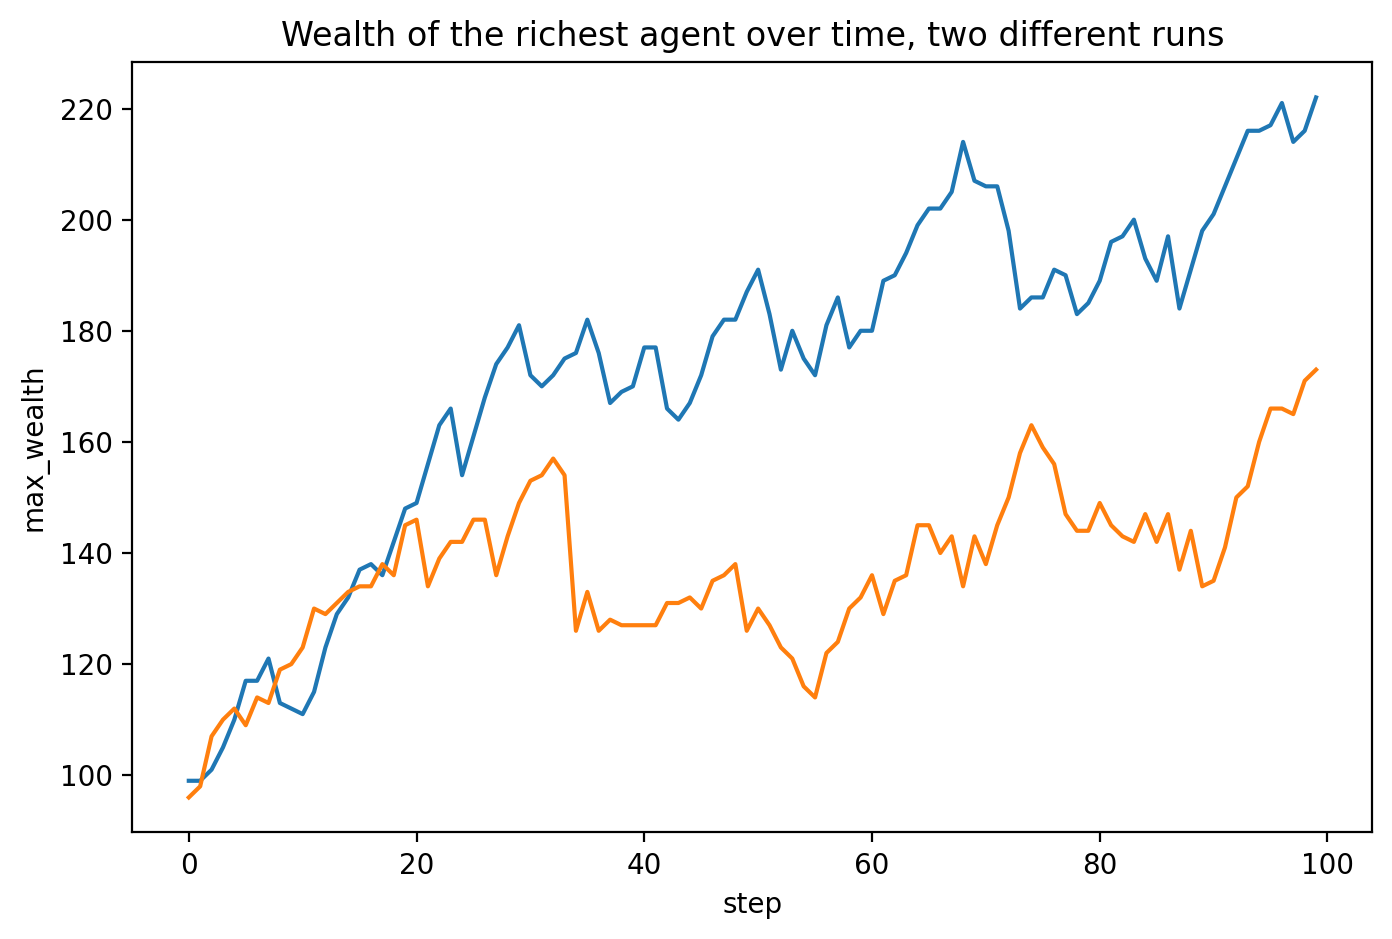

In [12]:
fig, ax = plt.subplots(figsize=(8,5), dpi=200)
sns.lineplot(data = model_data, x = 'step', y = 'max_wealth')
sns.lineplot(data = model_data_1, x = 'step', y = 'max_wealth')

plt.title('Wealth of the richest agent over time, two different runs')

# What is going on here ? Why are the two graphs not the same ?

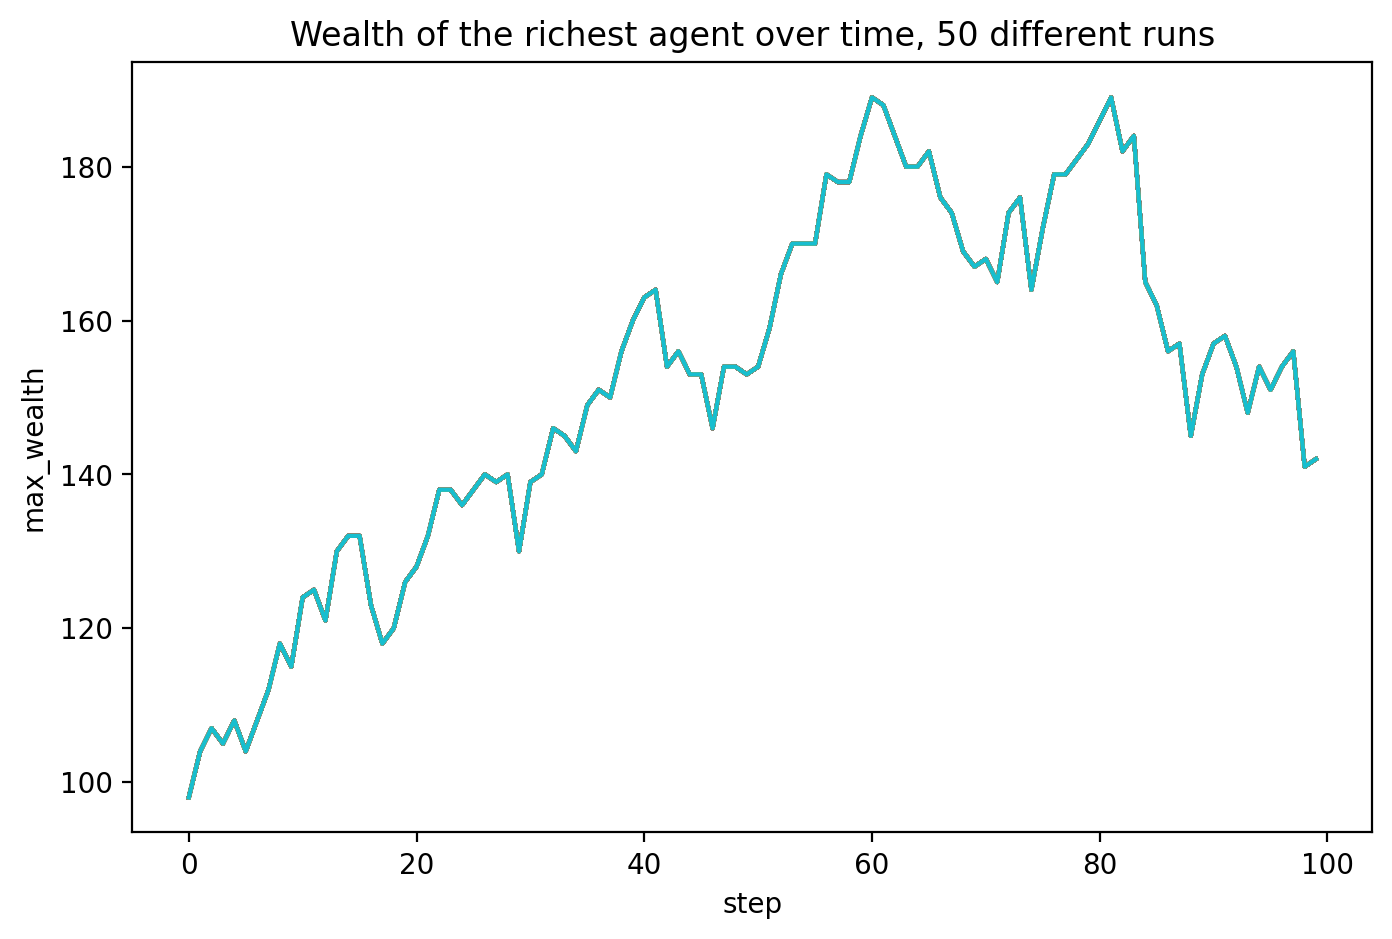

In [13]:
#lets do more runs but now with a fixed seed. 

fig, ax = plt.subplots(figsize=(8,5), dpi=200)

plt.title('Wealth of the richest agent over time, 50 different runs')
for rep in range(50):
    model = MoneyModel(100, seed = 42) # Try another seed value ;)
    for i in range(100):
        model.step()
    model_data = model.datacollector.get_model_vars_dataframe()
    ax = sns.lineplot(data = model_data, x = 'step', y = 'max_wealth')

In [ ]:
#As you can see, all 50 curves are overlapped, which means the seed works. 
#Every time we initiate a model with the same seed, we get the same curve. We did this 50 times and we got the same result every time

#Question: what if we want to fix the seed per repetition, so every repetition has a unique seed? 
#try to do this and see what you get

       

# Part 4 -  Effect of the scheduler

In [15]:
#lets change the scheduler to base instead of Random Activation

class MoneyModel_1(Model):
    """A model with some number of agents."""
    def __init__(self, N, max_init_money = 100, max_take_money = 10,seed=None):
        self.num_agents = N
        #self.schedule = time.RandomActivation(self)
        self.schedule = time.BaseScheduler(self)
        
        #the data collector, defines which variables will eb collected, and how
        model_metrics = {
                "step":get_step_number,
                "agent_wealth":get_agents_wealth,
                "max_wealth":max_wealth,
                "richest_agent":richest,
            }
        agent_metrics = {
            "wealth":"wealth"
        }
        self.datacollector = DataCollector(model_reporters=model_metrics,agent_reporters=agent_metrics)
    
        # Create agents
        for i in range(self.num_agents):
            a = MoneyAgent(i, self, max_init_money, max_take_money )
            self.schedule.add(a)

    def step(self):
        '''Advance the model by one step.'''  
        #collect the model data 
        self.datacollector.collect(self)
        #run the step
        self.schedule.step()
        

In [16]:
#now lets run the model again :
model_1 = MoneyModel(100, seed=42)
model_2 = MoneyModel_1(100, seed=42)

for i in range(100):
    model_1.step()
    model_2.step()
#lets save the data    
#Get the Pandas Dataframe from the model, by using the table name we defined in the model
model_data_1 = model_1.datacollector.get_model_vars_dataframe()
model_data_2 = model_2.datacollector.get_model_vars_dataframe()

agent_data_1 = model_1.datacollector.get_agent_vars_dataframe()
agent_data_2 = model_2.datacollector.get_agent_vars_dataframe()

In [17]:
#now lets run the model again :
model_1 = MoneyModel(100, seed=42)
for i in range(100):
    model_1.step()

model_2 = MoneyModel_1(100, seed=42)
for i in range(100):

    model_2.step()
#lets save the data    
#Get the Pandas Dataframe from the model, by using the table name we defined in the model
model_data_1 = model_1.datacollector.get_model_vars_dataframe()
model_data_2 = model_2.datacollector.get_model_vars_dataframe()

agent_data_1 = model_1.datacollector.get_agent_vars_dataframe()
agent_data_2 = model_2.datacollector.get_agent_vars_dataframe()

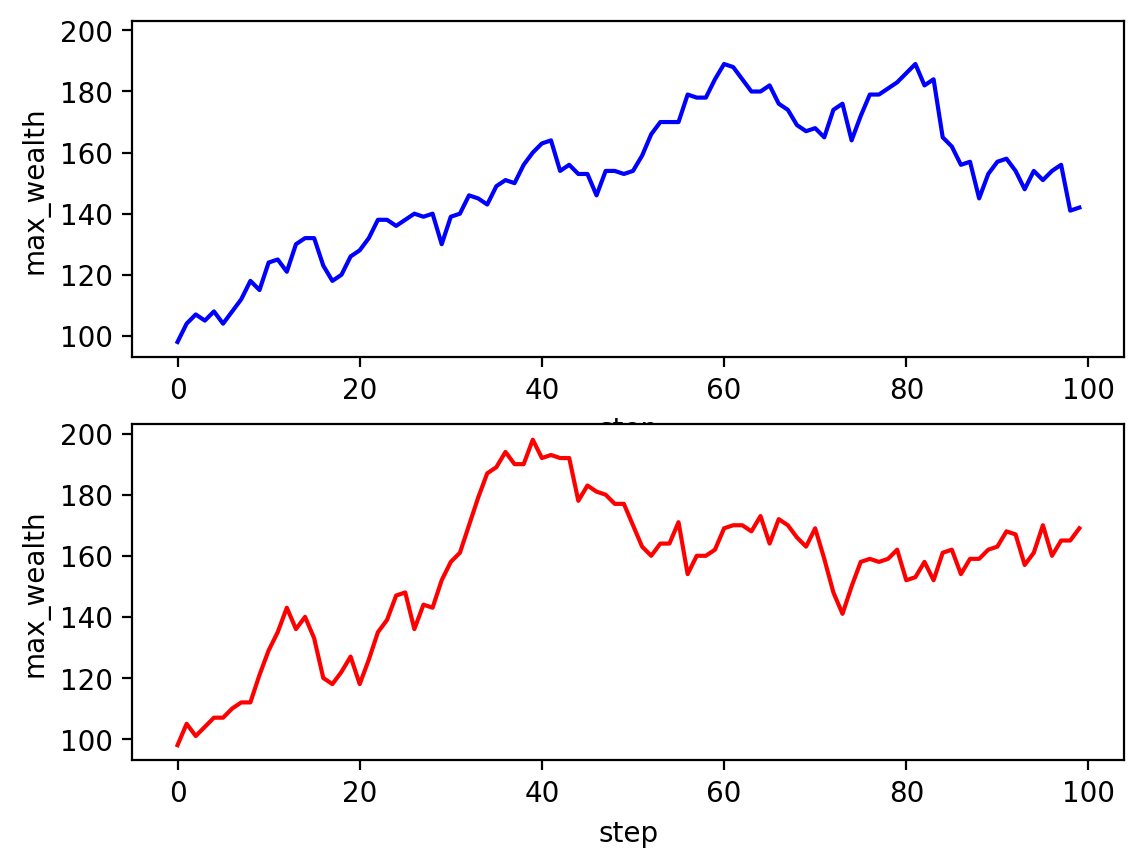

In [18]:
#create a plot of the richest agent over time , for  the two runs with different scheduler, on different plots
#Notice that we are using  subplots and we specify nroows to be 2. You can also use ncols for the number of columns. 
#You can also combine them for a matrix of graphs.
#Notice that we specify which axis is which, using (ax1,ax2)

fig, (ax1,ax2) = plt.subplots(nrows=2, sharey=True, dpi=200)

ax1 = sns.lineplot(data = model_data_1, x = 'step', y = 'max_wealth', color = 'blue', ax = ax1)
ax1 = sns.lineplot(data = model_data_2, x = 'step', y = 'max_wealth', color = 'red', ax = ax2)




In [ ]:
# make a histogram with seaborn that compares the distribution of wealth at the last tick, with the two schedulers
# Try creating two different plots, one below the other, and a single plot, with the two experiments having different colors


# Task : 
Explore the model with different values for starting money and money to take,  and show the difference of the effect of the random seed and the scheduler

Make :
Plot of max wealth over time, distribution of money at t=0 and t=100 (3 graphs in a subplot),  with the model running using the same fixed seed. :
 
* with BaseScheduler and RandomActivation schedule
  * with low initial money, low money_to_take
  * with high initial money, low money_to_take
  * with low initial money, high money_to_take
  * with high initial money, high money_to_take